In [6]:
import pandas as pd

# Read files related to train data

In [11]:
datapath= 'C:/Users/vincentlee/Desktop/datascienceprojects/Kaggle/ashrae/'

In [12]:
train             = pd.read_csv(datapath+ 'train.csv', nrows=2000)
building_metadata = pd.read_csv(datapath+ 'building_metadata.csv')
weather_train     = pd.read_csv(datapath+ 'weather_train.csv')

In [17]:
df= pd.DataFrame(building_metadata)
df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,7,799,Education,527431,1976.0,26.0
1,7,798,Education,409028,1970.0,21.0
2,7,802,Education,290625,1995.0,19.0
3,1,130,Lodging/residential,62893,1960.0,16.0
4,4,595,Education,270413,1971.0,14.0


In [24]:
df.shape

(1449, 6)

# Functions

In [6]:
#missing value computation
def cal_missing_val(df):
    data_dict = {}
    for col in df.columns:
        data_dict[col] = df[col].isnull().sum()/df.shape[0]*100
    return pd.DataFrame.from_dict(data_dict, orient='index', columns=['MissingValue'])

## EDA - Missing value 

In [7]:
missing_weather  = cal_missing_val(weather_train)
missing_building = cal_missing_val(building_metadata)

In [8]:
missing_weather

,MissingValue
site_id,0.000000
timestamp,0.000000
air_temperature,0.039350
cloud_coverage,49.489529
dew_temperature,0.080845
precip_depth_1_hr,35.979052
sea_level_pressure,7.596603
wind_direction,4.484414
wind_speed,0.217496


In [9]:
missing_building

,MissingValue
site_id,0.000000
building_id,0.000000
primary_use,0.000000
square_feet,0.000000
year_built,53.416149
floor_count,75.500345


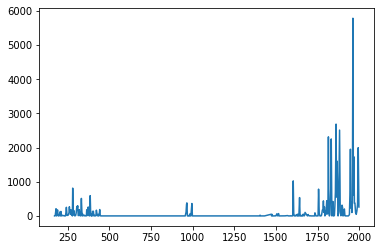

In [19]:
import matplotlib.pyplot as plt
plt.plot(train[train['meter'] == 1]['meter_reading'])
plt.show()

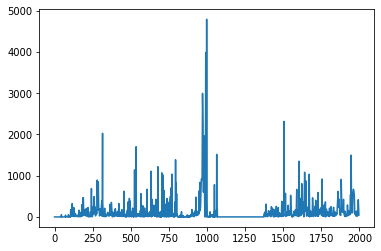

In [20]:
plt.plot(train[train['meter'] == 0]['meter_reading'])
plt.show()

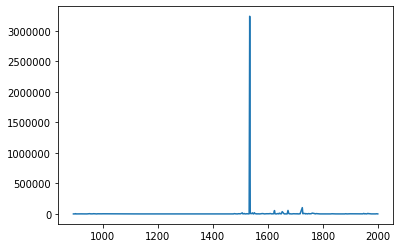

In [21]:
plt.plot(train[train['meter'] == 2]['meter_reading'])
plt.show()

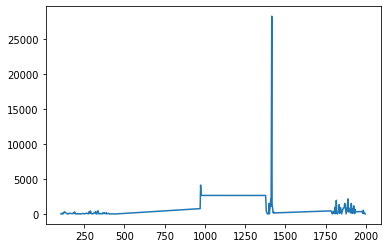

In [23]:
plt.plot(train[train['meter'] == 3]['meter_reading'])
plt.show()

## Imputation - Missing value 

### Floor_count (Method Linear regression)

In [67]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelBinarizer

In [68]:
building_metadata_part = building_metadata[['building_id','site_id','primary_use','square_feet', 'floor_count']]
cols    = ['primary_use', 'site_id']
encode_df = pd.DataFrame()
for col in cols:
    lb_style   = LabelBinarizer()
    lb_results = lb_style.fit_transform(building_metadata_part[col])
    label_code = pd.DataFrame(lb_results, columns=lb_style.classes_)
    encode_df  = pd.concat([encode_df, label_code], axis=1)
    
buidling_encode = pd.concat([encode_df, building_metadata_part[['building_id','square_feet', 'floor_count']]], axis=1)
buidling_encode = buidling_encode.set_index('building_id')
test            = buidling_encode[buidling_encode['floor_count'].isnull()]
train           = buidling_encode[buidling_encode['floor_count'].notnull()]
model           = LinearRegression()
X_test          = test.drop(['floor_count'],axis=1)
X_train         = train.iloc[:,:-1].values
Y_train         = train['floor_count'].values
building_model  = model.fit(X_train, Y_train)
y_pred          = building_model.predict(X_test)
X_test['floor_count'] = np.around(y_pred).astype(int)
combine_data    = pd.concat([train, X_test], axis=0)
building_metadata_noNA = pd.merge(building_metadata[['site_id', 'building_id', 'primary_use', 'square_feet', 'year_built']],
                            combine_data[['floor_count']], how='inner',left_index=True, right_index=True)

### Floor_count (Method MICE)

This type of imputation works by filling the missing data multiple times. 
Multiple Imputations (MIs) are much better than a single imputation as it measures the uncertainty of 
the missing values in a better way. The chained equations approach is also very flexible and can handle 
different variables of different data types (ie., continuous or binary) as well as complexities such as bounds 
or survey skip patterns.

In [69]:
from impyute.imputation.cs import mice
imputed_floorcount = mice(building_metadata[['floor_count', 'square_feet']].values)

Other methods to calculate floor_counts
Group by siteid or primaryuse and then calculate specific means/medians to fill in.
Calculate mean energy consumption of building with missing floor_count, then find buildings with similar energy consumptions taking into account other comparable features.

### KNN

In [14]:
!pip install fancyimpute

  Using cached https://files.pythonhosted.org/packages/d9/ed/90e0a13ad7ac4e7cdc2aeaefed26cebb4922f205bb778199268863fa2fbe/cvxpy-1.0.25.tar.gz
  Using cached https://files.pythonhosted.org/packages/b9/3a/59aa93b573a22fda44402383aeddcc2a081c31e61080af3da9d11855c77a/ecos-2.0.7.post1.tar.gz
  Using cached https://files.pythonhosted.org/packages/f2/6e/dbdd778c64c1920ae357a2013ea655d65a1f8b60f397d6e5549e4aafe8ec/scs-2.1.1-2.tar.gz
  Complete output from command C:\Users\vincentlee\Anaconda3\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\VINCEN~1\\AppData\\Local\\Temp\\pip-install-11zcnoun\\cvxpy\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d C:\Users\VINCEN~1\AppData\Local\Temp\pip-wheel-q9rkd09m --python-tag cp37:
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.7
  creating build\lib.win-amd64-3.7\cvxpy
  c

  Failed building wheel for cvxpy
  Failed building wheel for ecos
  Failed building wheel for scs
Command "C:\Users\vincentlee\Anaconda3\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\VINCEN~1\\AppData\\Local\\Temp\\pip-install-11zcnoun\\ecos\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record C:\Users\VINCEN~1\AppData\Local\Temp\pip-record-iwpd4w_4\install-record.txt --single-version-externally-managed --compile" failed with error code 1 in C:\Users\VINCEN~1\AppData\Local\Temp\pip-install-11zcnoun\ecos\


In [15]:
!pip install datawig

  Found existing installation: urllib3 1.24.1
    Uninstalling urllib3-1.24.1:
      Successfully uninstalled urllib3-1.24.1
  Found existing installation: idna 2.7
    Uninstalling idna-2.7:
      Successfully uninstalled idna-2.7
  Found existing installation: requests 2.20.0
    Uninstalling requests-2.20.0:
      Successfully uninstalled requests-2.20.0


optimuspyspark 2.2.22 has requirement requests==2.20.0, but you'll have requests 2.18.4 which is incompatible.
h2o-pysparkling-2-4 2.4.12 has requirement pyspark<=2.4.0,>=2.4.0, but you'll have pyspark 2.4.1 which is incompatible.
mxnet 1.5.0 has requirement numpy<1.17.0,>=1.8.2, but you'll have numpy 1.17.0 which is incompatible.


In [16]:
from fancyimpute import KNN    
# X is the complete data matrix
# X_incomplete has the same values as X except a subset have been replace with NaN

# Use 3 nearest rows which have a feature to fill in each row's missing features
df_filled_knn = KNN(k=3).complete(df)

ModuleNotFoundError: No module named 'fancyimpute'

In [25]:
import datawig

df_train, df_test = datawig.utils.random_split(df)

#Initialize a SimpleImputer model
imputer = datawig.SimpleImputer(
    input_columns=['primary_use','square_feet'], 
    # column(s) containing information about the column we want to impute
    output_column= 'floor_count', # the column we'd like to impute values for
    output_path = 'imputer_model' # stores model data and metrics
    )

#Fit an imputer model on the train data
imputer.fit(train_df=df_train, num_epochs=50)

#Impute missing values and return original dataframe with predictions
imputed = imputer.predict(df_test)

2019-11-14 06:22:25,471 [INFO]  
========== start: fit model
2019-11-14 06:22:25,473 [WARNING]  Already bound, ignoring bind()
2019-11-14 06:22:25,585 [INFO]  Epoch[0] Batch [0-33]	Speed: 5042.02 samples/sec	cross-entropy=15.922030	floor_count-accuracy=12.205882
2019-11-14 06:22:25,681 [INFO]  Epoch[0] Train-cross-entropy=15.766465
2019-11-14 06:22:25,682 [INFO]  Epoch[0] Train-floor_count-accuracy=12.031250
2019-11-14 06:22:25,683 [INFO]  Epoch[0] Time cost=0.206
2019-11-14 06:22:25,687 [INFO]  Saved checkpoint to "imputer_model\model-0000.params"
2019-11-14 06:22:25,692 [INFO]  Epoch[0] Validation-cross-entropy=61.825594
2019-11-14 06:22:25,693 [INFO]  Epoch[0] Validation-floor_count-accuracy=0.000000
2019-11-14 06:22:25,802 [INFO]  Epoch[1] Batch [0-33]	Speed: 5139.96 samples/sec	cross-entropy=14.516469	floor_count-accuracy=12.205882
2019-11-14 06:22:25,896 [INFO]  Epoch[1] Train-cross-entropy=15.554568
2019-11-14 06:22:25,897 [INFO]  Epoch[1] Train-floor_count-accuracy=12.031250
20

2019-11-14 06:22:28,695 [INFO]  Epoch[13] Validation-cross-entropy=60.641521
2019-11-14 06:22:28,696 [INFO]  Epoch[13] Validation-floor_count-accuracy=0.000000
2019-11-14 06:22:28,800 [INFO]  Epoch[14] Batch [0-33]	Speed: 5345.04 samples/sec	cross-entropy=14.288857	floor_count-accuracy=12.205882
2019-11-14 06:22:28,913 [INFO]  Epoch[14] Train-cross-entropy=14.450737
2019-11-14 06:22:28,914 [INFO]  Epoch[14] Train-floor_count-accuracy=12.031250
2019-11-14 06:22:28,915 [INFO]  Epoch[14] Time cost=0.217
2019-11-14 06:22:28,920 [INFO]  Saved checkpoint to "imputer_model\model-0014.params"
2019-11-14 06:22:28,926 [INFO]  Epoch[14] Validation-cross-entropy=60.593008
2019-11-14 06:22:28,928 [INFO]  Epoch[14] Validation-floor_count-accuracy=0.000000
2019-11-14 06:22:29,040 [INFO]  Epoch[15] Batch [0-33]	Speed: 4994.48 samples/sec	cross-entropy=14.286228	floor_count-accuracy=12.205882
2019-11-14 06:22:29,144 [INFO]  Epoch[15] Train-cross-entropy=14.426017
2019-11-14 06:22:29,145 [INFO]  Epoch[1

2019-11-14 06:22:31,865 [INFO]  Saved checkpoint to "imputer_model\model-0027.params"
2019-11-14 06:22:31,871 [INFO]  No improvement detected for 5 epochs compared to 60.427541732788086 last error obtained: 60.44233512878418, stopping here
2019-11-14 06:22:31,872 [INFO]  
========== done (6.400881767272949 s) fit model


In [26]:
imputed

,site_id,building_id,primary_use,square_feet,year_built,floor_count,floor_count_imputed
1409,15,1409,Lodging/residential,48881,1902.0,NaN,3.939383
265,5,711,Education,15414,1976.0,1.0,3.360658
320,8,850,Public services,28590,NaN,1.0,3.273683
560,2,256,Education,16744,NaN,NaN,3.381831
1395,15,1395,Lodging/residential,98624,NaN,NaN,3.987331
851,3,547,Healthcare,23903,NaN,NaN,3.048084
63,1,123,Education,61204,1989.0,6.0,3.879843
889,6,765,Entertainment/public assembly,58562,NaN,NaN,3.308999
144,12,1055,Education,86714,NaN,4.0,3.880062
219,5,728,Education,30300,1966.0,2.0,3.582305


In [32]:
import sklearn
SimpleImputer.score(X_train, y_train)
SimpleImputer.score(X_test, y_test)

AttributeError: type object 'SimpleImputer' has no attribute 'score'